<a href="https://colab.research.google.com/github/electropavuk/nn/blob/master/lab7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторна робота №7
#### з дисципліни "Нейронні мережі"
#### студента групи КН-31/2
#### Мауріна Андрія
#### Варіант №4

In [ ]:
!pip install yfinance

In [2]:
import math 
import numpy as np 
import pandas as pd 
from datetime import date, timedelta, datetime 
from pandas.plotting import register_matplotlib_converters 
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates 
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error 
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import LSTM, Dense, Dropout 
from tensorflow.keras.callbacks import EarlyStopping 
from sklearn.preprocessing import RobustScaler, MinMaxScaler 
import seaborn as sns 
sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})


physical_devices = tf.config.list_physical_devices('GPU')

end_date =  date.today().strftime("%Y-%m-%d")
start_date = '2010-01-01'

stockname = 'NASDAQ'
symbol = '^IXIC'

import yfinance as yf
df = yf.download(symbol, start=start_date, end=end_date)

df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,2294.409912,2311.149902,2294.409912,2308.419922,2308.419922,1931380000
2010-01-05,2307.270020,2313.729980,2295.620117,2308.709961,2308.709961,2367860000
2010-01-06,2307.709961,2314.070068,2295.679932,2301.090088,2301.090088,2253340000
2010-01-07,2298.090088,2301.300049,2285.219971,2300.050049,2300.050049,2270050000
2010-01-08,2292.239990,2317.600098,2290.610107,2317.169922,2317.169922,2145390000


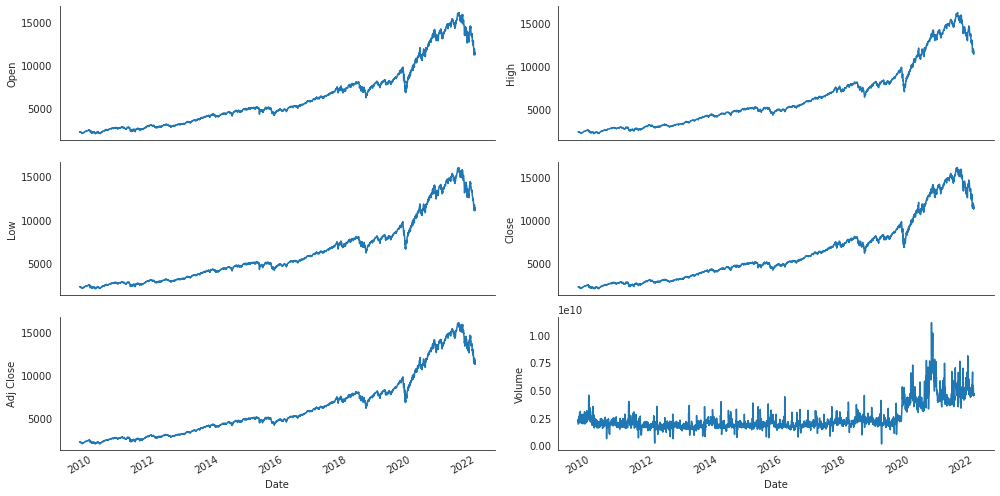

In [3]:

df_plot = df.copy()

ncols = 2
nrows = int(round(df_plot.shape[1] / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

In [4]:
train_df = df.sort_values(by=['Date']).copy()

FEATURES = ['High', 'Low', 'Open', 'Close', 'Volume']

data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close']

data_filtered_ext.tail()

,High,Low,Open,Close,Volume,Prediction
Date,,,,,,
2022-05-20,11552.209961,11035.690430,11542.669922,11354.620117,5413140000,11354.620117
2022-05-23,11552.070312,11304.559570,11396.280273,11535.269531,4509640000,11535.269531
2022-05-24,11351.610352,11092.480469,11326.440430,11264.450195,4706300000,11264.450195
2022-05-25,11511.900391,11211.849609,11225.030273,11434.740234,4500920000,11434.740234
2022-05-26,11796.969727,11406.160156,11409.839844,11740.650391,4651470000,11740.650391


In [5]:
nrows = data_filtered.shape[0]

np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(3122, 5)


In [6]:
sequence_length = 50

index_Close = data.columns.get_loc("Close")

train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    x = np.array(x)
    y = np.array(y)
    return x, y

x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(2448, 50, 5) (2448,)
(624, 50, 5) (624,)
0.02128794868212508
0.02128794868212508


In [7]:

model = Sequential()


n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))


model.compile(optimizer='adam', loss='mse')

250 50 5


In [8]:
epochs = 50
batch_size = 16
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(
    x_train, y_train, 
    batch_size=batch_size, 
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=[early_stop],
)

Epoch 1/50
153/153 [==============================] - 14s 21ms/step - loss: 9.3354e-04 - val_loss: 0.0011
Epoch 2/50
153/153 [==============================] - 2s 10ms/step - loss: 4.8981e-05 - val_loss: 8.4312e-04
Epoch 3/50
153/153 [==============================] - 1s 9ms/step - loss: 6.4639e-05 - val_loss: 0.0015
Epoch 4/50
153/153 [==============================] - 1s 9ms/step - loss: 5.2685e-05 - val_loss: 0.0012
Epoch 5/50
153/153 [==============================] - 1s 9ms/step - loss: 5.0190e-05 - val_loss: 5.3723e-04
Epoch 6/50
153/153 [==============================] - 1s 9ms/step - loss: 4.6587e-05 - val_loss: 0.0010
Epoch 7/50
153/153 [==============================] - 1s 9ms/step - loss: 5.9698e-05 - val_loss: 4.9589e-04
Epoch 8/50
153/153 [==============================] - 1s 9ms/step - loss: 5.2929e-05 - val_loss: 0.0012
Epoch 9/50
153/153 [==============================] - 1s 9ms/step - loss: 3.9843e-05 - val_loss: 4.5132e-04
Epoch 10/50
153/153 [========================

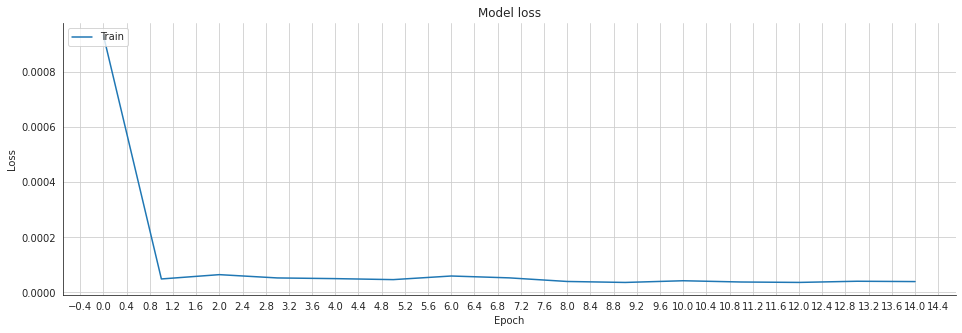

In [9]:
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [10]:
y_pred_scaled = model.predict(x_test)

y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

Median Absolute Error (MAE): 223.7
Mean Absolute Percentage Error (MAPE): 1.85 %
Median Absolute Percentage Error (MDAPE): 1.54 %


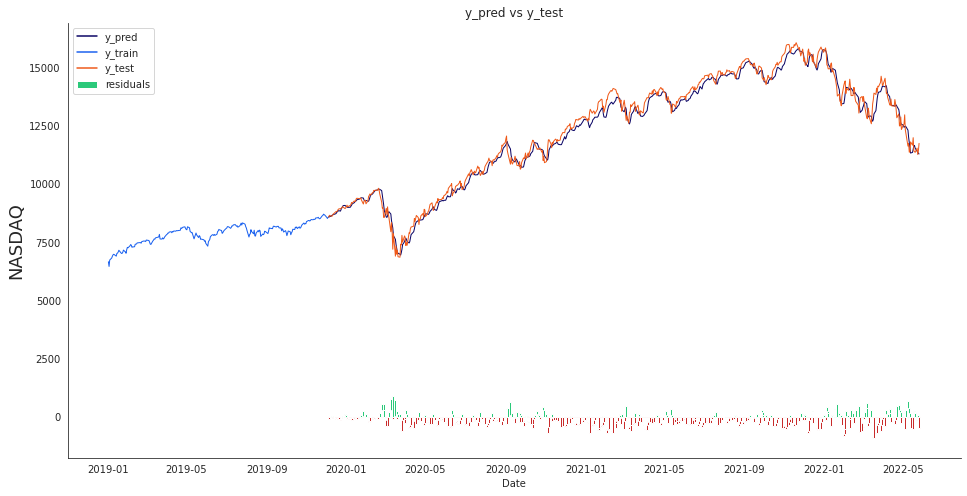

In [11]:
display_start_date = "2019-01-01" 

train = pd.DataFrame(data_filtered_ext['Close'][:train_data_len + 1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(data_filtered_ext['Close'][train_data_len:]).rename(columns={'Close': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

df_union_zoom = df_union[df_union.index > display_start_date]

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("y_pred vs y_test")
plt.ylabel(stockname, fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
plt.legend()
plt.show()

In [12]:
df_temp = df[-sequence_length:]
new_df = df_temp.filter(FEATURES)

N = sequence_length

last_N_days = new_df[-sequence_length:].values
last_N_days_scaled = scaler.transform(last_N_days)

X_test_new = []
X_test_new.append(last_N_days_scaled)

pred_price_scaled = model.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

price_today = np.round(new_df['Close'][-1], 2)
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

plus = '+'; minus = ''
print(f'The close price for {stockname} at {end_date} was {price_today}')
print(f'The predicted close price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')

The close price for NASDAQ at 2022-05-27 was 11740.65
The predicted close price is 11367.9404296875 (-3.28%)


# Висновок

За допомогою моделей які працюють на часових послідовностях можна передбачувати подальше значення функції наприклад для погоди. На інформації яка пов'язана із фінансами це мало можна застосовувати, тому що часто ціна регулюється попитом і пропозицією, а не функціональною залежністю. Тому часто при спробах вирішити цю задачу для передбачення ціни, модель отримую оверфіт. Для більш вдалої моделі необхідно більше даних і комбінування різних підходів.